In [1]:
import pandas as pd
import torch

from datasets import load_dataset
import evaluate
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import DataLoader
import torch
from torch import nn
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
original_df = pd.read_csv('all_parts.csv')

In [3]:
original_df

,id,article_date_timestamp,article_title,article_url,source,score,category,content
0,229,1.695244e+09,Phishing victim sends eye-watering $4.5M in US...,https://cointelegraph.com/news/phishing-victim...,Cointelegraph,0,none,An unwitting cryptocurrency holder has reporte...
1,237,1.695280e+09,Venmo добавил поддержку стейблкоина PayPal,https://forklog.com/news/venmo-dobavil-podderz...,Forklog,0,none,NaN
2,238,0.000000e+00,Джейми Куттс: «Выбросы CO2 в сети Биткоина про...,https://bits.media/dzheymi-kutts-vybrosy-co2-v...,BitsMedia,0,none,Аналитик Bloomberg Intelligence Джейми Куттс з...
3,239,0.000000e+00,Пользователи Venmo получили доступ к платежам ...,https://bits.media/polzovateli-venmo-poluchili...,BitsMedia,0,none,Крупная американская платежная компания PayPal...
4,240,1.695282e+09,Минфин определил порядок бухгалтерского учета ...,https://forklog.com/news/minfin-opredelil-pory...,Forklog,0,none,NaN
...,...,...,...,...,...,...,...,...
4018,6434,1.710577e+09,"G7 industry ministers commit to ""safe and reli...",http://en.people.cn/n3/2024/0316/c90000-201458...,People's Daily,1,ai,"G7 industry ministers commit to ""safe and reli..."
4019,6435,1.710763e+09,Saudi Arabia establishes AI Centre of Excellen...,https://www.investing.com/news/stock-market-ne...,Investing.com,1,ai,"Published Mar 18, 2024 07:49AM ET\n\n© Reuters..."
4020,6436,1.710763e+09,China’s PBOC facilitates global access to e-CN...,https://www.cryptopolitan.com/china-facilitate...,Cryptopolitan,1,cbdc,The People’s Bank of China (PBOC) has recently...
4021,6437,1.710519e+09,Swiss digital identity law approved by parliam...,https://www.biometricupdate.com/202403/swiss-d...,Biometric,1,bid,The Swiss parliament is preparing to debate a ...


In [4]:
cleaned_df = original_df.loc[:, ['category', 'article_title', 'content']].dropna()

In [5]:
cleaned_df

,category,article_title,content
0,none,Phishing victim sends eye-watering $4.5M in US...,An unwitting cryptocurrency holder has reporte...
2,none,Джейми Куттс: «Выбросы CO2 в сети Биткоина про...,Аналитик Bloomberg Intelligence Джейми Куттс з...
3,none,Пользователи Venmo получили доступ к платежам ...,Крупная американская платежная компания PayPal...
8,none,Хешрейт по осени считают: как регулируют майни...,Майнинг биткоина и других криптовалют — крупне...
9,none,Bitcoin Holding Above $26K Is ‘Remarkable’ as ...,Bitcoin Holding Above $26K Is ‘Remarkable’ as ...
...,...,...,...
4017,ai,Abu Dhabi sets up investment firm to achieve A...,The United Arab Emirates is inching forward wi...
4018,ai,"G7 industry ministers commit to ""safe and reli...","G7 industry ministers commit to ""safe and reli..."
4019,ai,Saudi Arabia establishes AI Centre of Excellen...,"Published Mar 18, 2024 07:49AM ET\n\n© Reuters..."
4020,cbdc,China’s PBOC facilitates global access to e-CN...,The People’s Bank of China (PBOC) has recently...


In [6]:
cleaned_df['category'].value_counts()

category
none    1102
cr       454
ai       159
cbdc     150
oth       99
bid       57
tok       51
defi      18
api        3
Name: count, dtype: int64

In [7]:
# cleaned_df.loc[cleaned_df['category']=='none', 'category'] = 'oth'

In [8]:
cleaned_df['category'].value_counts()

category
none    1102
cr       454
ai       159
cbdc     150
oth       99
bid       57
tok       51
defi      18
api        3
Name: count, dtype: int64

In [9]:
cleaned_df['text'] = cleaned_df['article_title'] + '\n' + cleaned_df['content']

In [10]:
df = cleaned_df.loc[:, ['text', 'category']].rename(columns={"category": "labels"})

In [11]:
df

,text,labels
0,Phishing victim sends eye-watering $4.5M in US...,none
2,Джейми Куттс: «Выбросы CO2 в сети Биткоина про...,none
3,Пользователи Venmo получили доступ к платежам ...,none
8,Хешрейт по осени считают: как регулируют майни...,none
9,Bitcoin Holding Above $26K Is ‘Remarkable’ as ...,none
...,...,...
4017,Abu Dhabi sets up investment firm to achieve A...,ai
4018,"G7 industry ministers commit to ""safe and reli...",ai
4019,Saudi Arabia establishes AI Centre of Excellen...,ai
4020,China’s PBOC facilitates global access to e-CN...,cbdc


In [12]:
df.to_csv('multiclass.csv', index=False)

In [13]:
df['labels'].value_counts().sort_index()

labels
ai       159
api        3
bid       57
cbdc     150
cr       454
defi      18
none    1102
oth       99
tok       51
Name: count, dtype: int64

In [14]:
class_weights = (1 - (df['labels'].value_counts().sort_index() / len(df))).values
class_weights

array([0.92403249, 0.99856665, 0.97276636, 0.92833254, 0.78308648,
       0.9913999 , 0.47348304, 0.95269947, 0.97563306])

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_weights = torch.from_numpy(class_weights).float().to(device)
class_weights

tensor([0.9240, 0.9986, 0.9728, 0.9283, 0.7831, 0.9914, 0.4735, 0.9527, 0.9756],
       device='cuda:0')

In [16]:
def get_dataset(csv_path, test_size=0.2):
    full_dataset = load_dataset('csv', data_files=csv_path)
    full_dataset = full_dataset.filter(lambda example: example['text'] is not None and example['labels'] is not None)
    full_dataset = full_dataset.class_encode_column("labels")
    dataset = full_dataset['train'].train_test_split(test_size=test_size, stratify_by_column='labels')
    return dataset

In [17]:
dataset = get_dataset('multiclass.csv')

Generating train split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/2093 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/2093 [00:00<?, ? examples/s]

In [18]:
labels = sorted(df['labels'].value_counts().keys())  # .sort_index()

In [19]:
id2label = {}
label2id = {}

In [20]:
for i, label in enumerate(labels):
    id2label[i] = label
    label2id[label] = i

In [21]:
pd.Series(dataset['train']['labels']).value_counts()

6    881
4    363
0    127
3    120
7     79
2     46
8     41
5     14
1      3
Name: count, dtype: int64

In [22]:
dataset['train'][0]

{'text': 'Hong Kong ‘ready’ to capitalize on crypto’s next bull run: Hashkey Capital\nHong Kong is “very ready” for the next wave of mass crypto adoption, with an influx of crypto talent that has been spilling into the aspiring digital asset hub, says Jupiter Zheng, a partner at Hashkey Capital.\n\nSpeaking to Cointelegraph, Zheng, partner of liquid funds and research at the investment arm of Hong Kong crypto firm HashKey Group — explained that the combination of new Web3 projects along with crypto-positive regulatory developments has primed Hong Kong for significant growth in the next four to five years.\n\n“You’ve got all of these new, different projects, with their founders and teams here, which is all real GDP by the way. These teams are already boosting both banking and capital market activities."\n\nZheng added that while crypto prices haven’t reflected it, the level of sophistication being developed in the sector over the past 18 months had been striking.\n\n“The actual technolo

In [23]:
model_name = "distilbert/distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)

In [24]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [25]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/1674 [00:00<?, ? examples/s]

Map:   0%|          | 0/419 [00:00<?, ? examples/s]

In [26]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [27]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(labels), id2label=id2label, label2id=label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [29]:
from transformers import AdamW, get_scheduler

dataset_len = (dataset['train'].num_rows + dataset['test'].num_rows)

optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 3
num_training_steps = num_epochs * dataset_len


lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps= int(0.1 * num_epochs * dataset_len),
    num_training_steps=num_training_steps
)

c:\Users\ODOBESKURS\AppData\Local\miniconda3\envs\fintech_cb_pro\lib\site-packages\transformers\optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [30]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        
        outputs = model(**inputs)
        logits = outputs.get('logits')
        
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss

In [31]:
f1_metric = evaluate.load('f1')

training_args = TrainingArguments(
    output_dir="./results/multiclass-distilbert2/",
    num_train_epochs=50,
    per_device_train_batch_size=24,
    per_device_eval_batch_size=24,
    warmup_steps=200,
    weight_decay=0.01,
    logging_strategy='no',
    evaluation_strategy="steps",
    eval_steps=50,
    save_only_model=True,
    save_strategy="steps",
    save_steps=50,
    save_total_limit=2,
    metric_for_best_model='f1',
    greater_is_better=True,
    eval_accumulation_steps=32,
    fp16=True,  # mixed precision
    load_best_model_at_end = True,
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return f1_metric.compute(predictions=predictions, references=labels, average='macro')

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
    optimizers=[optimizer, lr_scheduler],
)

In [32]:
trainer.train()

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 2.142705202102661, 'eval_f1': 0.02236199849200365, 'eval_runtime': 1.0964, 'eval_samples_per_second': 382.17, 'eval_steps_per_second': 16.418, 'epoch': 0.71}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.846754550933838, 'eval_f1': 0.1427647819442812, 'eval_runtime': 1.08, 'eval_samples_per_second': 387.946, 'eval_steps_per_second': 16.666, 'epoch': 1.43}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.670335292816162, 'eval_f1': 0.1427647819442812, 'eval_runtime': 1.0864, 'eval_samples_per_second': 385.68, 'eval_steps_per_second': 16.569, 'epoch': 2.14}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.5965787172317505, 'eval_f1': 0.1419982488568927, 'eval_runtime': 1.0829, 'eval_samples_per_second': 386.916, 'eval_steps_per_second': 16.622, 'epoch': 2.86}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.4697415828704834, 'eval_f1': 0.21596582569602552, 'eval_runtime': 1.0824, 'eval_samples_per_second': 387.119, 'eval_steps_per_second': 16.63, 'epoch': 3.57}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.296247124671936, 'eval_f1': 0.2727246080279553, 'eval_runtime': 1.086, 'eval_samples_per_second': 385.806, 'eval_steps_per_second': 16.574, 'epoch': 4.29}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.1614899635314941, 'eval_f1': 0.40842447335943627, 'eval_runtime': 1.0994, 'eval_samples_per_second': 381.107, 'eval_steps_per_second': 16.372, 'epoch': 5.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.0989043712615967, 'eval_f1': 0.44837545609971896, 'eval_runtime': 1.0916, 'eval_samples_per_second': 383.835, 'eval_steps_per_second': 16.489, 'epoch': 5.71}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.0236637592315674, 'eval_f1': 0.47053409693957987, 'eval_runtime': 1.0935, 'eval_samples_per_second': 383.162, 'eval_steps_per_second': 16.46, 'epoch': 6.43}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.9981508851051331, 'eval_f1': 0.48092277677403295, 'eval_runtime': 1.1024, 'eval_samples_per_second': 380.066, 'eval_steps_per_second': 16.327, 'epoch': 7.14}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.9392784237861633, 'eval_f1': 0.536243759143497, 'eval_runtime': 1.0933, 'eval_samples_per_second': 383.256, 'eval_steps_per_second': 16.464, 'epoch': 7.86}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.8852601647377014, 'eval_f1': 0.557102138520208, 'eval_runtime': 1.0969, 'eval_samples_per_second': 381.977, 'eval_steps_per_second': 16.41, 'epoch': 8.57}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.9139729738235474, 'eval_f1': 0.6027133588536597, 'eval_runtime': 1.0976, 'eval_samples_per_second': 381.753, 'eval_steps_per_second': 16.4, 'epoch': 9.29}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.9387201070785522, 'eval_f1': 0.6105346505822736, 'eval_runtime': 1.0876, 'eval_samples_per_second': 385.248, 'eval_steps_per_second': 16.55, 'epoch': 10.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.867154061794281, 'eval_f1': 0.6314708639062088, 'eval_runtime': 1.0974, 'eval_samples_per_second': 381.829, 'eval_steps_per_second': 16.403, 'epoch': 10.71}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.9836744070053101, 'eval_f1': 0.6245361870943567, 'eval_runtime': 1.096, 'eval_samples_per_second': 382.295, 'eval_steps_per_second': 16.423, 'epoch': 11.43}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.8991674184799194, 'eval_f1': 0.6475304729390825, 'eval_runtime': 1.0987, 'eval_samples_per_second': 381.356, 'eval_steps_per_second': 16.383, 'epoch': 12.14}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.0796056985855103, 'eval_f1': 0.588181408837281, 'eval_runtime': 1.0959, 'eval_samples_per_second': 382.327, 'eval_steps_per_second': 16.425, 'epoch': 12.86}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.019862174987793, 'eval_f1': 0.6617543267519959, 'eval_runtime': 1.1075, 'eval_samples_per_second': 378.326, 'eval_steps_per_second': 16.253, 'epoch': 13.57}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.083228349685669, 'eval_f1': 0.6753003188899482, 'eval_runtime': 1.0952, 'eval_samples_per_second': 382.578, 'eval_steps_per_second': 16.435, 'epoch': 14.29}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.0843168497085571, 'eval_f1': 0.6210087529808077, 'eval_runtime': 1.0925, 'eval_samples_per_second': 383.542, 'eval_steps_per_second': 16.477, 'epoch': 15.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.109995722770691, 'eval_f1': 0.6634779670052613, 'eval_runtime': 1.0932, 'eval_samples_per_second': 383.291, 'eval_steps_per_second': 16.466, 'epoch': 15.71}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.0848751068115234, 'eval_f1': 0.7443951448618156, 'eval_runtime': 1.0895, 'eval_samples_per_second': 384.569, 'eval_steps_per_second': 16.521, 'epoch': 16.43}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.2408937215805054, 'eval_f1': 0.6800593333468068, 'eval_runtime': 1.1009, 'eval_samples_per_second': 380.594, 'eval_steps_per_second': 16.35, 'epoch': 17.14}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.177653193473816, 'eval_f1': 0.7167611879289609, 'eval_runtime': 1.0964, 'eval_samples_per_second': 382.143, 'eval_steps_per_second': 16.417, 'epoch': 17.86}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.2421369552612305, 'eval_f1': 0.6921319435032078, 'eval_runtime': 1.102, 'eval_samples_per_second': 380.206, 'eval_steps_per_second': 16.333, 'epoch': 18.57}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.297851800918579, 'eval_f1': 0.7301703884299431, 'eval_runtime': 1.1085, 'eval_samples_per_second': 377.998, 'eval_steps_per_second': 16.239, 'epoch': 19.29}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.31304931640625, 'eval_f1': 0.728649637594998, 'eval_runtime': 1.1011, 'eval_samples_per_second': 380.526, 'eval_steps_per_second': 16.347, 'epoch': 20.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.3394880294799805, 'eval_f1': 0.736018823660737, 'eval_runtime': 1.0953, 'eval_samples_per_second': 382.534, 'eval_steps_per_second': 16.433, 'epoch': 20.71}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.4385857582092285, 'eval_f1': 0.7282620732034462, 'eval_runtime': 1.0925, 'eval_samples_per_second': 383.507, 'eval_steps_per_second': 16.475, 'epoch': 21.43}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.4892590045928955, 'eval_f1': 0.7375947756083594, 'eval_runtime': 1.1046, 'eval_samples_per_second': 379.317, 'eval_steps_per_second': 16.295, 'epoch': 22.14}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.409603238105774, 'eval_f1': 0.617051415987734, 'eval_runtime': 1.0903, 'eval_samples_per_second': 384.292, 'eval_steps_per_second': 16.509, 'epoch': 22.86}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.4943991899490356, 'eval_f1': 0.641530487495025, 'eval_runtime': 1.0903, 'eval_samples_per_second': 384.309, 'eval_steps_per_second': 16.51, 'epoch': 23.57}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.6574835777282715, 'eval_f1': 0.6715361704564982, 'eval_runtime': 1.092, 'eval_samples_per_second': 383.687, 'eval_steps_per_second': 16.483, 'epoch': 24.29}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.6172831058502197, 'eval_f1': 0.7145429421990754, 'eval_runtime': 1.0984, 'eval_samples_per_second': 381.447, 'eval_steps_per_second': 16.387, 'epoch': 25.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.6599493026733398, 'eval_f1': 0.698520613683222, 'eval_runtime': 1.0949, 'eval_samples_per_second': 382.671, 'eval_steps_per_second': 16.439, 'epoch': 25.71}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.5902636051177979, 'eval_f1': 0.7107393399768329, 'eval_runtime': 1.0936, 'eval_samples_per_second': 383.146, 'eval_steps_per_second': 16.46, 'epoch': 26.43}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.6167371273040771, 'eval_f1': 0.7377898257663716, 'eval_runtime': 1.0936, 'eval_samples_per_second': 383.148, 'eval_steps_per_second': 16.46, 'epoch': 27.14}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.5842580795288086, 'eval_f1': 0.7330479449350065, 'eval_runtime': 1.0935, 'eval_samples_per_second': 383.188, 'eval_steps_per_second': 16.462, 'epoch': 27.86}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.6194648742675781, 'eval_f1': 0.7563631631692318, 'eval_runtime': 1.099, 'eval_samples_per_second': 381.259, 'eval_steps_per_second': 16.379, 'epoch': 28.57}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.670838713645935, 'eval_f1': 0.7384710501991607, 'eval_runtime': 1.104, 'eval_samples_per_second': 379.546, 'eval_steps_per_second': 16.305, 'epoch': 29.29}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.7265297174453735, 'eval_f1': 0.7321004870563217, 'eval_runtime': 1.0973, 'eval_samples_per_second': 381.861, 'eval_steps_per_second': 16.405, 'epoch': 30.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.6351830959320068, 'eval_f1': 0.7588843621934653, 'eval_runtime': 1.0915, 'eval_samples_per_second': 383.877, 'eval_steps_per_second': 16.491, 'epoch': 30.71}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.5841851234436035, 'eval_f1': 0.7366630595858641, 'eval_runtime': 1.1008, 'eval_samples_per_second': 380.641, 'eval_steps_per_second': 16.352, 'epoch': 31.43}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.6323274374008179, 'eval_f1': 0.7336918291163866, 'eval_runtime': 1.0993, 'eval_samples_per_second': 381.135, 'eval_steps_per_second': 16.373, 'epoch': 32.14}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.757596492767334, 'eval_f1': 0.7531895206492873, 'eval_runtime': 1.0939, 'eval_samples_per_second': 383.049, 'eval_steps_per_second': 16.456, 'epoch': 32.86}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.7460246086120605, 'eval_f1': 0.7238546003811448, 'eval_runtime': 1.0954, 'eval_samples_per_second': 382.501, 'eval_steps_per_second': 16.432, 'epoch': 33.57}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.6283634901046753, 'eval_f1': 0.7463423261438725, 'eval_runtime': 1.0983, 'eval_samples_per_second': 381.485, 'eval_steps_per_second': 16.388, 'epoch': 34.29}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.7110780477523804, 'eval_f1': 0.7603819895892265, 'eval_runtime': 1.0897, 'eval_samples_per_second': 384.508, 'eval_steps_per_second': 16.518, 'epoch': 35.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.7494150400161743, 'eval_f1': 0.7158452547913687, 'eval_runtime': 1.0941, 'eval_samples_per_second': 382.955, 'eval_steps_per_second': 16.452, 'epoch': 35.71}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.7164466381072998, 'eval_f1': 0.7111538649786542, 'eval_runtime': 1.1005, 'eval_samples_per_second': 380.727, 'eval_steps_per_second': 16.356, 'epoch': 36.43}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.7832368612289429, 'eval_f1': 0.6991297700214172, 'eval_runtime': 1.0894, 'eval_samples_per_second': 384.604, 'eval_steps_per_second': 16.522, 'epoch': 37.14}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.776075839996338, 'eval_f1': 0.7137739061149538, 'eval_runtime': 1.1069, 'eval_samples_per_second': 378.541, 'eval_steps_per_second': 16.262, 'epoch': 37.86}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.8271026611328125, 'eval_f1': 0.7103761116556506, 'eval_runtime': 1.1043, 'eval_samples_per_second': 379.412, 'eval_steps_per_second': 16.299, 'epoch': 38.57}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.8178011178970337, 'eval_f1': 0.7261217389282868, 'eval_runtime': 1.0975, 'eval_samples_per_second': 381.785, 'eval_steps_per_second': 16.401, 'epoch': 39.29}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.8850709199905396, 'eval_f1': 0.7087101659112529, 'eval_runtime': 1.0944, 'eval_samples_per_second': 382.862, 'eval_steps_per_second': 16.448, 'epoch': 40.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.9118168354034424, 'eval_f1': 0.7089670933773914, 'eval_runtime': 1.0919, 'eval_samples_per_second': 383.741, 'eval_steps_per_second': 16.485, 'epoch': 40.71}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.937444806098938, 'eval_f1': 0.7470588448797078, 'eval_runtime': 1.0985, 'eval_samples_per_second': 381.413, 'eval_steps_per_second': 16.385, 'epoch': 41.43}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.7976540327072144, 'eval_f1': 0.7252726194394441, 'eval_runtime': 1.0955, 'eval_samples_per_second': 382.457, 'eval_steps_per_second': 16.43, 'epoch': 42.14}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.8841207027435303, 'eval_f1': 0.7202351010982939, 'eval_runtime': 1.0923, 'eval_samples_per_second': 383.6, 'eval_steps_per_second': 16.479, 'epoch': 42.86}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 2.0452849864959717, 'eval_f1': 0.7422413821214938, 'eval_runtime': 1.1004, 'eval_samples_per_second': 380.78, 'eval_steps_per_second': 16.358, 'epoch': 43.57}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.902132272720337, 'eval_f1': 0.7321022706424839, 'eval_runtime': 1.103, 'eval_samples_per_second': 379.858, 'eval_steps_per_second': 16.318, 'epoch': 44.29}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.9669971466064453, 'eval_f1': 0.7269858492204142, 'eval_runtime': 1.0983, 'eval_samples_per_second': 381.484, 'eval_steps_per_second': 16.388, 'epoch': 45.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.8869584798812866, 'eval_f1': 0.7338410284257042, 'eval_runtime': 1.0956, 'eval_samples_per_second': 382.429, 'eval_steps_per_second': 16.429, 'epoch': 45.71}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.9589576721191406, 'eval_f1': 0.7393021208169892, 'eval_runtime': 1.111, 'eval_samples_per_second': 377.127, 'eval_steps_per_second': 16.201, 'epoch': 46.43}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.9856116771697998, 'eval_f1': 0.7449120967824081, 'eval_runtime': 1.0984, 'eval_samples_per_second': 381.457, 'eval_steps_per_second': 16.387, 'epoch': 47.14}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.9696930646896362, 'eval_f1': 0.7299256207859984, 'eval_runtime': 1.0974, 'eval_samples_per_second': 381.82, 'eval_steps_per_second': 16.403, 'epoch': 47.86}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.9809372425079346, 'eval_f1': 0.7287171763006237, 'eval_runtime': 1.0963, 'eval_samples_per_second': 382.178, 'eval_steps_per_second': 16.418, 'epoch': 48.57}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.9771294593811035, 'eval_f1': 0.7323114694838229, 'eval_runtime': 1.1081, 'eval_samples_per_second': 378.131, 'eval_steps_per_second': 16.244, 'epoch': 49.29}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.9682074785232544, 'eval_f1': 0.7283656589130723, 'eval_runtime': 1.0934, 'eval_samples_per_second': 383.208, 'eval_steps_per_second': 16.462, 'epoch': 50.0}
{'train_runtime': 721.136, 'train_samples_per_second': 116.067, 'train_steps_per_second': 4.853, 'train_loss': 0.28922591727120534, 'epoch': 50.0}


TrainOutput(global_step=3500, training_loss=0.28922591727120534, metrics={'train_runtime': 721.136, 'train_samples_per_second': 116.067, 'train_steps_per_second': 4.853, 'train_loss': 0.28922591727120534, 'epoch': 50.0})

In [33]:
from tqdm import tqdm


y_pred = []
y_true = tokenized_dataset["test"]['labels']
with torch.no_grad():
    for i in tqdm(range(len(tokenized_dataset["test"]))):
        logits = model(**tokenizer(tokenized_dataset["test"][i]['text'], max_length=512, truncation=True, return_tensors="pt").to(device))
    
        predicted_class_id = logits.logits.argmax().item()
        # model.config.id2label[predicted_class_id]
    
        y_pred.append(predicted_class_id)


100%|██████████| 419/419 [00:03<00:00, 125.78it/s]


In [34]:
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report

f1_score(y_true, y_pred, average='macro')

0.7603819895892265

In [35]:
recall_score(y_true, y_pred, average='macro')

0.7371358880090497

In [36]:
precision_score(y_true, y_pred, average='macro')

0.7954706498249191

In [37]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.78      0.85        32
           2       1.00      1.00      1.00        11
           3       0.71      0.80      0.75        30
           4       0.72      0.69      0.70        91
           5       1.00      0.75      0.86         4
           6       0.80      0.82      0.81       221
           7       0.50      0.55      0.52        20
           8       0.71      0.50      0.59        10

    accuracy                           0.77       419
   macro avg       0.80      0.74      0.76       419
weighted avg       0.78      0.77      0.77       419



In [38]:
eval_loss_history = []
eval_f1_history = []
steps = []
for obj in trainer.state.log_history:
    eval_loss_history.append(obj.get('eval_loss'))
    steps.append(obj.get('step'))
    eval_f1_history.append(obj.get('eval_f1'))

In [39]:
eval_loss_history = eval_loss_history[:-1]
eval_f1_history = eval_f1_history[:-1]
steps = steps[:-1]

<Axes: >

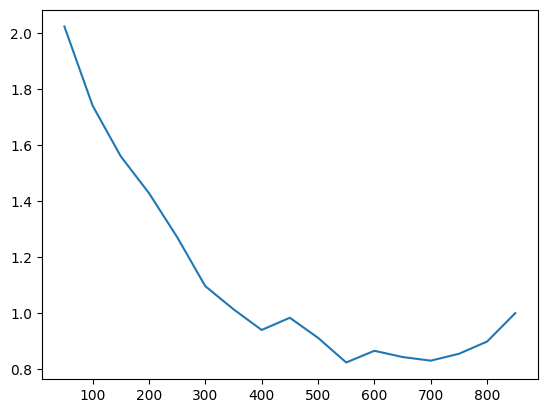

In [40]:
sns.lineplot(x=steps[:len(steps)//4], y=eval_loss_history[:len(eval_loss_history)//4])

<Axes: >

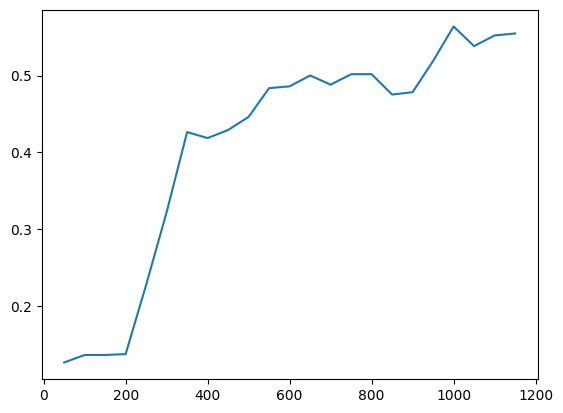

In [41]:
sns.lineplot(x=steps[:len(steps)//3], y=eval_f1_history[:len(steps)//3])